In [107]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For full reproducibility (slightly slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


In [108]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
import numpy as np
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
print(data.files)
embeddings = data['test_embeddings']
print("shape of embeddings:" , embeddings.shape)
probs= data['probs']
print("shape of probs:", probs.shape)
y_labels = data['y_labels']
print("Shape of labels:", y_labels.shape)
y_true = data['y_train']
print("Shape of y_true:", y_true.shape)


['test_embeddings', 'y_train', 'y_labels', 'audio_num', 'probs', 'audio_names']
shape of embeddings: (5702, 64)
shape of probs: (5702, 12)
Shape of labels: (5702,)
Shape of y_true: (5702, 12)


In [109]:
#Predicted class
y_hat = np.argmax(probs, axis=1)
print("predicted class :", y_hat.shape)
#Prob of predicted class
p_y_hat = np.max(probs, axis=1)
print("predicted probabilities :", p_y_hat.shape)

#True class one hot matrix
y_star= y_true
print("true class :", y_star)
#Prob of true class
p_y_star = np.sum(probs * y_star, axis=1)
print("true class probabilities :", p_y_star.shape)

#True class labels
y_true_class = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
print("true class labels :", y_true_class)
def compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha):
    indicator = (y_true_class != y_hat).astype(float)
    numerator = p_y_star
    denominator = p_y_hat + (indicator * (p_y_star + alpha))
    tcp_star_targets = numerator / denominator
    return tcp_star_targets

tcp_star_targets = compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha=0.6)
print("tcp_star_targets shape:", tcp_star_targets.shape)

predicted class : (5702,)
predicted probabilities : (5702,)
true class : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]
true class probabilities : (5702,)
true class labels : [ 8 11 11 ... 11  9  1]
tcp_star_targets shape: (5702,)


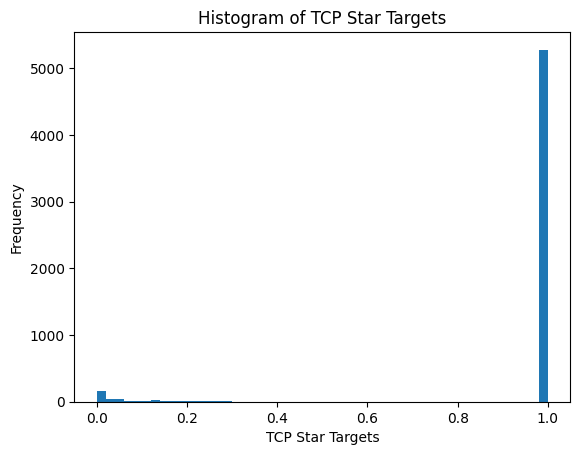

In [110]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_star_targets, bins=50)
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets')
plt.show()

In [111]:
from sklearn.model_selection import train_test_split

X= embeddings
y = tcp_star_targets
from sklearn.model_selection import train_test_split

all_indices = np.arange(len(embeddings))  
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

# Now use these to split all your arrays
X_train = embeddings[train_indices]
y_train = tcp_star_targets[train_indices]

X_test = embeddings[test_indices]
y_test = tcp_star_targets[test_indices]

# Also for classifier outputs
y_hat_train = y_hat[train_indices]
y_true_class_train = y_true_class[train_indices]

In [112]:
import torch.nn as nn

class ConfidenceNet(nn.Module):
    def __init__(self, input_dim):
        super(ConfidenceNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


In [113]:
y_hat_train.shape, y_true_class_train.shape, X_train.shape

((4561,), (4561,), (4561, 64))

In [114]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim import AdamW

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Determine which are errors/successes on the training split
is_correct_train = (y_hat_train == y_true_class_train)
X_train_errors = X_train_tensor[~is_correct_train]
y_train_errors = y_train_tensor[~is_correct_train]

X_train_success = X_train_tensor[is_correct_train]
y_train_success = y_train_tensor[is_correct_train]

print(f"Errors in train: {len(X_train_errors)}, Successes in train: {len(X_train_success)}")

Errors in train: 342, Successes in train: 4219


In [115]:
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [116]:
error_batch_size = 64
success_batch_size = 64
num_epochs = 100
num_success_batches = len(X_train_success) // success_batch_size
num_error_batches = len(X_train_errors) // error_batch_size

print(f"Number of success batches: {num_success_batches}, Number of error batches: {num_error_batches}")

Number of success batches: 65, Number of error batches: 5


In [117]:
import random

from torch.optim.lr_scheduler import StepLR
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
input_dim = X_train.shape[1]
output_dim = 1
model = ConfidenceNet(input_dim)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.MSELoss()


# Training the model
for epoch in range(num_epochs):
    model.train()
    train_losses=[]
    #shuffle the success and errors
    perm_success= torch.randperm(len(X_train_success))
    perm_errors = torch.randperm(len(X_train_errors))

    X_success_shuffled = X_train_success[perm_success]
    y_success_shuffled = y_train_success[perm_success]
    X_errors_shuffled = X_train_errors[perm_errors]
    y_errors_shuffled = y_train_errors[perm_errors]

    #split into chunks

    success_chunks_X = X_success_shuffled.split(success_batch_size)
    success_chunks_y = y_success_shuffled.split(success_batch_size)
    error_chunks_X = list(X_errors_shuffled.split(error_batch_size))
    error_chunks_y = list(y_errors_shuffled.split(error_batch_size))


    # Iterate over success batches
    for i in range (num_success_batches):
        err_idx= i% num_error_batches

        print(
            f"Epoch {epoch+1}/{num_epochs} | success_chunk={i}/{num_success_batches-1} "
            f"| error_chunk={err_idx}/{num_error_batches-1}"
        )
        
        X_batch = torch.cat([
            success_chunks_X[i],
            error_chunks_X[err_idx]
        ])
        y_batch = torch.cat([
            success_chunks_y[i],
            error_chunks_y[err_idx]
        ])
        perm = torch.randperm(X_batch.size(0))
        X_batch = X_batch[perm]
        y_batch = y_batch[perm]
        pred = model(X_batch)
        weights=torch.ones_like(y_batch)
        weights[y_batch < 0.5] = 5.0  # Assign lower weight to errors
        weights[y_batch >= 0.5] = 1.0
        #loss = (criterion(pred, y_batch) * weights).mean()
        loss = (F.binary_cross_entropy(pred, y_batch, reduction='none') * weights).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = sum(train_losses) / len(train_losses)
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f}")

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())
    avg_val_loss = sum(val_losses) / len(val_losses)
    print(f"Epoch {epoch+1:02d} | Validation Loss: {avg_val_loss:.6f}")
    

Epoch 1/100 | success_chunk=0/64 | error_chunk=0/4
Epoch 1/100 | success_chunk=1/64 | error_chunk=1/4
Epoch 1/100 | success_chunk=2/64 | error_chunk=2/4
Epoch 1/100 | success_chunk=3/64 | error_chunk=3/4
Epoch 1/100 | success_chunk=4/64 | error_chunk=4/4
Epoch 1/100 | success_chunk=5/64 | error_chunk=0/4
Epoch 1/100 | success_chunk=6/64 | error_chunk=1/4
Epoch 1/100 | success_chunk=7/64 | error_chunk=2/4
Epoch 1/100 | success_chunk=8/64 | error_chunk=3/4
Epoch 1/100 | success_chunk=9/64 | error_chunk=4/4
Epoch 1/100 | success_chunk=10/64 | error_chunk=0/4
Epoch 1/100 | success_chunk=11/64 | error_chunk=1/4
Epoch 1/100 | success_chunk=12/64 | error_chunk=2/4
Epoch 1/100 | success_chunk=13/64 | error_chunk=3/4
Epoch 1/100 | success_chunk=14/64 | error_chunk=4/4
Epoch 1/100 | success_chunk=15/64 | error_chunk=0/4
Epoch 1/100 | success_chunk=16/64 | error_chunk=1/4
Epoch 1/100 | success_chunk=17/64 | error_chunk=2/4
Epoch 1/100 | success_chunk=18/64 | error_chunk=3/4
Epoch 1/100 | success_

In [ ]:
model.eval()
with torch.no_grad():
    Xall_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores_tcpr = model(Xall_tensor).cpu().numpy()  # shape: (1141,)

In [119]:
 confidence_scores_tcpr.shape


(5702,)

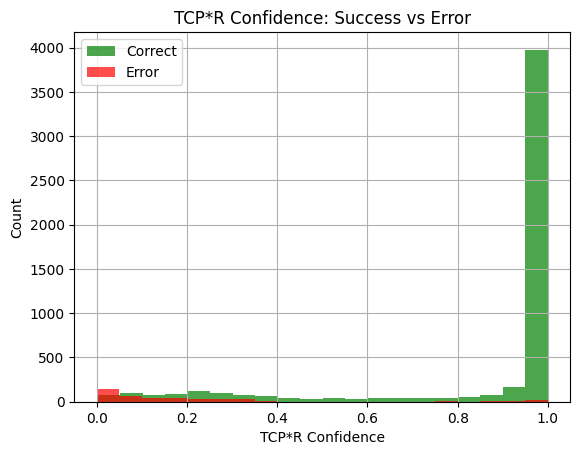

In [120]:
import matplotlib.pyplot as plt

is_correct_full = (y_hat == y_true_class)
success_conf = confidence_scores_tcpr[is_correct_full]
error_conf = confidence_scores_tcpr[~is_correct_full]

plt.hist(success_conf, bins=20, alpha=0.7, label='Correct', color='green')
plt.hist(error_conf, bins=20, alpha=0.7, label='Error', color='red')
plt.xlabel('TCP*R Confidence')
plt.ylabel('Count')
plt.title('TCP*R Confidence: Success vs Error')
plt.legend()
plt.grid(True)
plt.show()

In [121]:
def compute_ECE(confidences, predictions, labels, n_bins=15):
    """
    Compute Expected Calibration Error (ECE).

    confidences: np.array of predicted confidence scores (0 to 1)
    predictions: np.array of predicted classes
    labels: np.array of true classes
    n_bins: number of bins
    """
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            accuracy_in_bin = np.mean(accuracies[in_bin])
            bin_gap = abs(avg_confidence_in_bin - accuracy_in_bin)

            ece += prop_in_bin * bin_gap

    return ece



# Compute ECE for TCP*R confidence scores
ece_tcpr = compute_ECE(confidence_scores_tcpr, y_hat, y_true_class, n_bins=15)
print(f"ECE for TCP*R confidence scores: {ece_tcpr:.4f}")

ECE for TCP*R confidence scores: 0.1152


In [122]:
#calculate softmax ece 
ece_softmax = compute_ECE(p_y_hat, y_hat, y_true_class, n_bins=15)
print(f"ECE for Softmax probabilities: {ece_softmax:.4f}")

ECE for Softmax probabilities: 0.0120


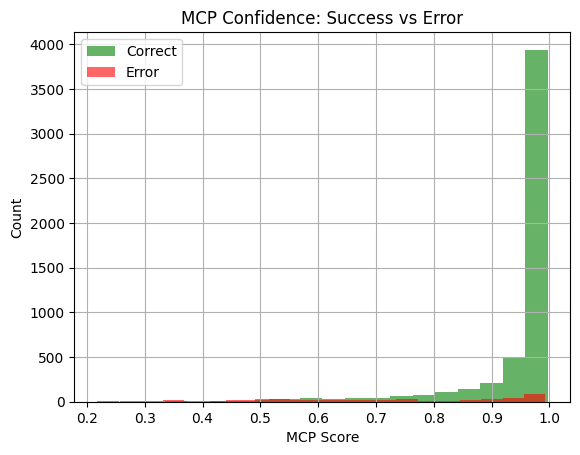

In [123]:
import numpy as np

# probs is shape (N, C) where N is number of samples and C is number of classes
mcp_scores = np.max(probs, axis=1)  # shape: (N,)
is_correct = (y_hat == y_true_class)
mcp_success = mcp_scores[is_correct]
mcp_error = mcp_scores[~is_correct]

plt.hist(mcp_success, bins=20, alpha=0.6, label="Correct", color="green")
plt.hist(mcp_error, bins=20, alpha=0.6, label="Error", color="red")
plt.xlabel("MCP Score")
plt.ylabel("Count")
plt.legend()
plt.title("MCP Confidence: Success vs Error")
plt.grid(True)
plt.show()

In [124]:
ece_mcp = compute_ECE(mcp_scores, y_hat, y_true_class)
print(f"ECE of MCP: {ece_mcp:.4f}")

ECE of MCP: 0.0120


In [125]:
# ECE with no weights
def compute_ECE_no_weights(confidences, predictions, labels, n_bins=15):
    """
    Compute Expected Calibration Error (ECE).

    confidences: np.array of predicted confidence scores (0 to 1)
    predictions: np.array of predicted classes
    labels: np.array of true classes
    n_bins: number of bins
    """
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            accuracy_in_bin = np.mean(accuracies[in_bin])
            bin_gap = abs(avg_confidence_in_bin - accuracy_in_bin)

            ece += bin_gap

    return ece



# Compute ECE for TCP*R confidence scores
ece_tcpr_no_weights = compute_ECE_no_weights(confidence_scores_tcpr, y_hat, y_true_class, n_bins=15)
print(f"ECE for TCP*R confidence scores: {ece_tcpr_no_weights:.4f}")

ECE for TCP*R confidence scores: 5.3430


In [126]:
#inverse weights
import numpy as np

def compute_ECE_inv(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    total_error = 0.0
    total_bin_mass = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        bin_size = np.sum(in_bin)

        if bin_size > 0:
            acc_in_bin = np.mean(accuracies[in_bin])
            conf_in_bin = np.mean(confidences[in_bin])
            bin_error = np.abs(conf_in_bin - acc_in_bin)

            total_error += bin_error
            total_bin_mass += bin_size / total_samples

    # Final inversion of total bin mass
    if total_bin_mass > 0:
        return total_error / total_bin_mass
    else:
        return 0.0
    
# Compute ECE for TCP*R confidence scores with inverse weights
ece_tcpr_inv = compute_ECE_inv(confidence_scores_tcpr, y_hat, y_true_class, n_bins=15)
print(f"ECE for TCP*R confidence scores with inverse weights: {ece_tcpr_inv:.4f}")

ECE for TCP*R confidence scores with inverse weights: 5.3430


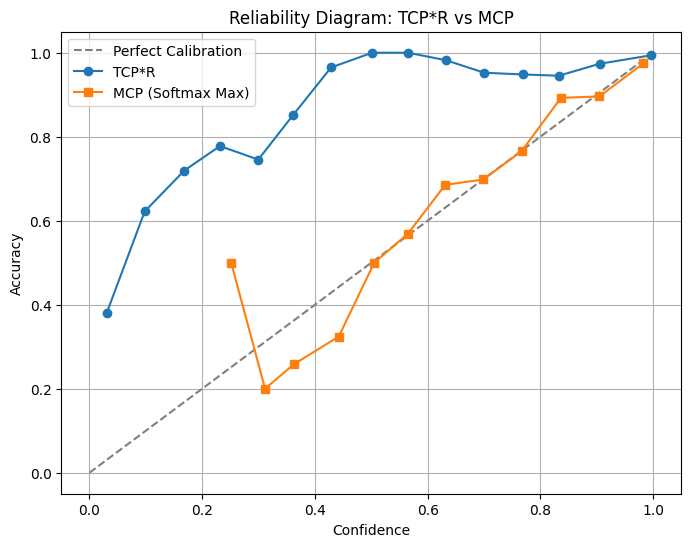

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Use 15 bins
n_bins = 15

# Compute calibration curves
def get_calibration_data(confidences, predictions, true_labels):
    accuracy = (predictions == true_labels)
    prob_true, prob_pred = calibration_curve(accuracy, confidences, n_bins=n_bins, strategy='uniform')
    return prob_pred, prob_true

# Get data
prob_pred_tcpr, prob_true_tcpr = get_calibration_data(confidence_scores_tcpr, y_hat, y_true_class)
prob_pred_mcp, prob_true_mcp = get_calibration_data(p_y_hat, y_hat, y_true_class)

# Plot
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfect Calibration')
plt.plot(prob_pred_tcpr, prob_true_tcpr, marker='o', label='TCP*R')
plt.plot(prob_pred_mcp, prob_true_mcp, marker='s', label='MCP (Softmax Max)')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram: TCP*R vs MCP')
plt.legend()
plt.grid(True)
plt.show()